This notebook is a part of **AwareAI** team project.

We automated the creation of a dataset containing biased and unbiased stories using OpenAI’s GPT-3.5 API, you can find the notebook [here for Biased Stories](https://colab.research.google.com/drive/1_YmiWieUVlT-JPlDXhfvJZUCK8Ljm4AO?usp=sharing). The second notebook is for [unbiased Stories](https://colab.research.google.com/drive/13-y0Xalh4THS4dpmq93TaYFRG_8cUhuk?usp=sharing).

Here is for the Arabic data: [Biased data](https://colab.research.google.com/drive/1JWYax7tYL_I0fdqz9sB8-VolFLyuDhta?usp=sharing), [unbiased data](https://colab.research.google.com/drive/1UQIAJt5zVsPaexolzxIX9Jdseg2YAO1X?usp=sharing).

The bias classification strategy encompasses two main avenues: utilizing [GPT-3.5 as a classifier](https://colab.research.google.com/drive/1UnU0caaPn8qjd6NGwSwOOrxb5T8VqeSA?usp=sharing) and
fine-tuning GPT-2 model for dedicated bias classification. Which is what this notebook about.

[Source](https://github.com/haocai1992/GPT2-News-Classifier/blob/main/colab-train/gpt2-news-classifier-colab-train.ipynb)

# Text Classification using fine-tuned GPT-2 model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1dMTdO5vxdVX0NA2Qe7AV9WGEy8ZH67Xn?usp=sharing) &nbsp;[![Generic badge](https://img.shields.io/badge/GitHub-Source-greensvg)](https://github.com/haocai1992/GPT2-News-Classifier/blob/main/colab-train/gpt2-news-classifier-colab-train.ipynb)

This notebook demonstrates how to use a pre-trained GPT-2 model from [HuggingFace](https://huggingface.co/transformers/) to perform text classification task.

Both BERT and GPT-2 are state-of-the-art transformer models (less "SOTA" now in 2022, with emergence of GPT-3 and other new ones...) that has phenomenal performance in many NLP tasks. One big difference between these two is that GPT-2 was built using decoder blocks, while BERT uses encoder blocks. Therefore, GPT-2 is mostly used in text-generation tasks. Unlike BERT, I couldn't find a lot of articles/tech blogs talking about using GPT-2 for **text classification** tasks. That's why I want to try that out here!

The **main idea** is this: Since GPT2 is a decoder transformer, the last token of the input sequence is used to make predictions about the next token that should follow the input. This means that the last token of the input sequence can be used to for predictions in a classification task too.

## Install and import packages

In [ ]:
 !pip3 install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio==0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
 !pip3 install pandas
 !pip3 install numpy
#  !pip3 install sklearn
 !pip3 install tqdm
 !pip3 install transformers

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Download and read data

In [ ]:
!wget -O Engish-Stories.csv https://www.dropbox.com/scl/fi/dvg2b17blzfk8yb6a6250/English-Stories.csv?rlkey=7jdvd3504xqtykesga568ranw&dl=0

--2023-08-22 08:35:18--  https://www.dropbox.com/scl/fi/dvg2b17blzfk8yb6a6250/English-Stories.csv?rlkey=7jdvd3504xqtykesga568ranw
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/e/scl/fi/dvg2b17blzfk8yb6a6250/English-Stories.csv?rlkey=7jdvd3504xqtykesga568ranw [following]
--2023-08-22 08:35:18--  https://www.dropbox.com/e/scl/fi/dvg2b17blzfk8yb6a6250/English-Stories.csv?rlkey=7jdvd3504xqtykesga568ranw
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc63b602c1d1c244687d7f13df51.dl.dropboxusercontent.com/cd/0/get/CCTVzqa1JgbHbIgqNj1JCLrH5DEj0dy4tWRm-astSpZnbA2cE7uxkqOVXTB_5nyAxGdNuA3xGm8E_SbswMM8evYQDrxsibQv9Ya_L_ylB-5B0gI0lpgsCcNeJA8ifzDJsYzbHwy31uGEdEfe0DDMs_ku/file# [following]
--2023-08-22 08:35:19--  https://

In [ ]:
import pandas as pd

file_path = 'Engish-Stories.csv'  # File downloaded using wget

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

The dataset we are going to use in this notebook is stories biased and unbiased. You can download the dataset [Dataset](https://drive.google.com/file/d/1PywdqupnoCCnPtaFhCJHSfxfQg6mS9lN/view?usp=sharing).

This dataset is in CSV format and it has 400 different texts, each labeled under one of 2 biased : yes or no. It has two columns, **biased** which will be the label; and **stories** which will be our input data for GPT-2.

## Preprocessing data (text tokenization)

We need to tokenize the input text in order to feed GPT-2 model with its expected data format. This can be easily done using HuggingFace Transformers' GPT2Tokenizer object. However, unlike BERT which does padding to the right, for GPT-2 we need to do padding to the left, because we need to use the last token for prediction. Therefore we need to adapt GPT2Tokenizer after calling.

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

## Dataset class

PyTorch provides a very convenient way to construct cusom Dataset class to facilitate model training. See more details [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Here we will build a custom Dataset class to read in our stories data, tokenize them, and store them into containers for batch training.

In [ ]:
labels = {
    "No": 0,
    "Yes": 1
         }

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['biased']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df['story']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

## Split training-test dataset

One more thing to do before we start with models. We need to split train, validation and test data as separate dataframes. Numpy's split function can do just that.

In [ ]:
np.random.seed(42)

df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=35),
                                     [int(0.8*len(df)), int(0.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

320 40 40


## Model building

Now comes to the most important part of this notebook. We need to buid a classifier model on top of a pre-trained GPT-2 model. The trick here is to add a linear layer on top of GPT-2's 12 layers of decoders with its output dimension equals our number of labels. In this way we can use GPT-2 to output 2 numbers which corresponds to our two biased categories!

In [ ]:
class SimpleGPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)


    def forward(self, input_id, mask):
        """
        Args:
                input_id: encoded inputs ids of sent.
        """
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

## Training loop

Now it's time to train (fine-tune) our model! Here I build a standard PyTorch training loop following [this guide](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html). Since this is a bainary-class classification problem,we picked [cross-entropy-loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) as our loss function ("criterion"), and [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) as the optimization algorithm.

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)

            model.zero_grad()

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc

            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")

EPOCHS = 30
model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=2, max_seq_len=128, gpt_model_name="gpt2")
LR = 9e-4

train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 160/160 [00:09<00:00, 16.59it/s]


Epochs: 1 | Train Loss:  3.520             | Train Accuracy:  0.537             | Val Loss:  0.399             | Val Accuracy:  0.525


100%|██████████| 160/160 [00:06<00:00, 26.21it/s]


Epochs: 2 | Train Loss:  0.291             | Train Accuracy:  0.681             | Val Loss:  0.073             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 25.73it/s]


Epochs: 3 | Train Loss:  0.028             | Train Accuracy:  0.975             | Val Loss:  0.705             | Val Accuracy:  0.575


100%|██████████| 160/160 [00:06<00:00, 26.49it/s]


Epochs: 4 | Train Loss:  0.005             | Train Accuracy:  0.997             | Val Loss:  0.015             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.27it/s]


Epochs: 5 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.021             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.37it/s]


Epochs: 6 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.025             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.05it/s]


Epochs: 7 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.027             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.23it/s]


Epochs: 8 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.029             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.16it/s]


Epochs: 9 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.031             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.46it/s]


Epochs: 10 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.033             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.11it/s]


Epochs: 11 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.034             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.55it/s]


Epochs: 12 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.036             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.27it/s]


Epochs: 13 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.037             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.56it/s]


Epochs: 14 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.038             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.19it/s]


Epochs: 15 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.039             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.43it/s]


Epochs: 16 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.039             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.31it/s]


Epochs: 17 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.040             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.38it/s]


Epochs: 18 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.041             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.29it/s]


Epochs: 19 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.041             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.41it/s]


Epochs: 20 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.042             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.35it/s]


Epochs: 21 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.042             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.33it/s]


Epochs: 22 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.042             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.29it/s]


Epochs: 23 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.043             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.07it/s]


Epochs: 24 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.043             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.17it/s]


Epochs: 25 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.043             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.30it/s]


Epochs: 26 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.044             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.22it/s]


Epochs: 27 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.044             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.25it/s]


Epochs: 28 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.044             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 25.90it/s]


Epochs: 29 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.045             | Val Accuracy:  0.975


100%|██████████| 160/160 [00:06<00:00, 26.45it/s]


Epochs: 30 | Train Loss:  0.000             | Train Accuracy:  1.000             | Val Loss:  0.045             | Val Accuracy:  0.975


## Evaluation

After model training, it's recommended to use the test data to evaluate the model performance on unseen data. I build the `evaluate` function according [this PyTorch guide](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html).

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()


    # Tracking variables
    predictions_labels = []
    true_labels = []

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

    return true_labels, predictions_labels

true_labels, pred_labels = evaluate(model, df_test)

Test Accuracy:  0.925


Another good gauge of model performance is the confusion matrix.

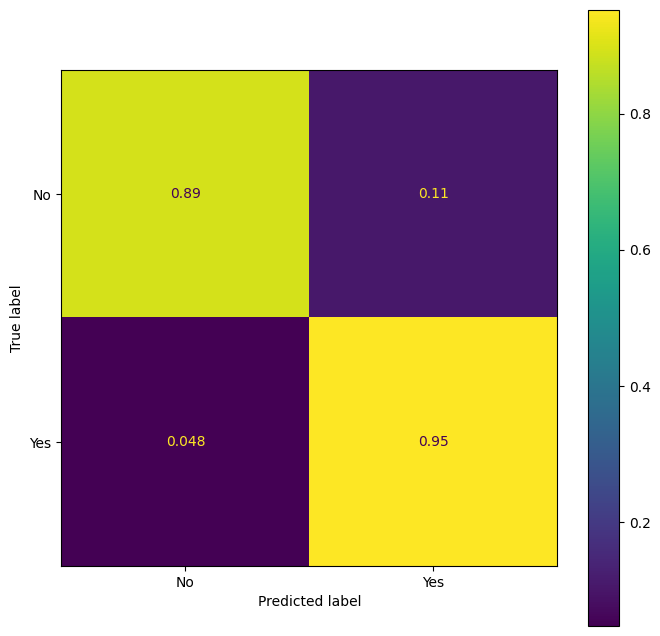

In [ ]:
# Plot confusion matrix.
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.keys()))
disp.plot(ax=ax)

## Saving and loading the model

After training, we need to save the model locally. PyTorch models store the learned parameters in an internal state dictionary, called state_dict. These can be persisted via the torch.save method:

In [ ]:
# save trained model
torch.save(model.state_dict(), "content")

In [ ]:
# save trained model
torch.save(model, "contentt")

In [ ]:
torch.save(model.state_dict(), 'model.pth')

# Prototype

In [ ]:
model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=2, max_seq_len=128, gpt_model_name="gpt2")

In [ ]:
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [ ]:
outer_input = "In a suburban town, Amina's kind spirit couldn't shield her from the isolation her Muslim identity brought. Misunderstandings persisted, leaving her lonely. Despite her soccer dreams, her hijab held her back, deepening her sorrow. Amina's silent struggle remained, underscoring the importance of empathy and acceptance in a world that failed to grasp her pain."
tokenized_outer_input = tokenizer(outer_input, padding='max_length', max_length=128, truncation=True, return_tensors="pt")

In [ ]:
tokenized = tokenizer(outer_input, padding="max_length", max_length=128, return_tensors="pt")

In [ ]:
input_ids = tokenized['input_ids']
attention_mask = tokenized['attention_mask']

In [ ]:
outputs = model(input_ids, attention_mask)

In [ ]:
logits = outputs.squeeze()

In [ ]:
if (torch.argmax(logits).item()) == 1:
  print("Biased")
else:
  print("Unbiased")

Biased
